# 🚗 Car Attack Detection - Extended Models
## Comprehensive ML Model Comparison for Intrusion Detection

This notebook extends the original analysis by adding **SVM, Random Forest, Logistic Regression, KNN, Neural Network (MLP), and Extra Trees** to the existing models (AdaBoost, Naive Bayes, Decision Tree, XGBoost).

**Total Models: 10**

## Section 1: Import Required Libraries & Create Encoder
*(Copied from original notebook)*

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the balanced dataset to create encoder
print("Loading dataset to create encoder...")
df = pd.read_csv('final_train_ready_scrubbed.csv')

# Create the encoder from the Label column
encoder = LabelEncoder()
encoder.fit(df['Label'])

print("Encoder created successfully!")
print(f"Label classes: {encoder.classes_}")

Loading dataset to create encoder...
Encoder created successfully!
Label classes: ['DoS' 'Fuzzy' 'Gear' 'Normal' 'RPM']


## Section 2: AdaBoost Hyperparameter Tuning (GridSearchCV)
*(Copied from original notebook)*

In [2]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import time

# 1. Load the scrubbed, balanced data
print("Loading dataset...")
df = pd.read_csv('final_train_ready_scrubbed.csv')

# 2. Split Features and Target
X = df.drop(columns=['Label_Encoded', 'Label'])
y = df['Label_Encoded']

# 3. Create a smaller subset for Tuning (e.g., 10% of data)
# This makes Grid Search finish in minutes instead of hours
_, X_tune, _, y_tune = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
print(f"Tuning on {len(X_tune)} samples...")

# 4. Define the Parameter Grid
# These are the "knobs" we will turn to find the best setting
param_grid = {
    'n_estimators': [50, 100],          # Number of trees (Paper used ~50, we test higher too)
    'learning_rate': [0.5, 1.0],        # How "aggressive" the learning is
    'estimator__max_depth': [1, 2, 3]   # Depth of the weak learners (Decision Trees)
}

# 5. Initialize the Base Model
# Note: In newer sklearn, 'base_estimator' is renamed to 'estimator'
base_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# 6. Setup Grid Search with 5-Fold CV (As per paper)
print("Starting Grid Search with 5-Fold CV...")
start_time = time.time()

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,               # 5-Fold Cross Validation
    scoring='accuracy', # We want to maximize Accuracy
    n_jobs=-1,          # Use all CPU cores
    verbose=1
)

grid_search.fit(X_tune, y_tune)

print(f"\nSearch completed in {time.time() - start_time:.2f} seconds.")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")
print("Best Parameters:", grid_search.best_params_)

Loading dataset...
Tuning on 76845 samples...
Starting Grid Search with 5-Fold CV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Search completed in 198.02 seconds.
Best Accuracy: 1.0000
Best Parameters: {'estimator__max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 100}


## Section 3: Final AdaBoost Model Training & Evaluation
*(Copied from original notebook)*

Loading full dataset for final training...

Using Best Parameters from GridSearch:
  n_estimators: 100
  learning_rate: 0.5
  max_depth: 3

Final Training Set Size: 614752 samples
Final Test Set Size: 153689 samples

Training FINAL AdaBoost model with best parameters...
Final model training completed!

Generating predictions...

FINAL MODEL ACCURACY: 100.00%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     31217
       Fuzzy       1.00      1.00      1.00     31217
        Gear       1.00      1.00      1.00     31217
      Normal       1.00      1.00      1.00     28821
         RPM       1.00      1.00      1.00     31217

    accuracy                           1.00    153689
   macro avg       1.00      1.00      1.00    153689
weighted avg       1.00      1.00      1.00    153689


CONFUSION MATRIX (Numerical)
[[31217     0     0     0     0]
 [    0 31217     0     0     0]
 [    0     0 31217     0     0

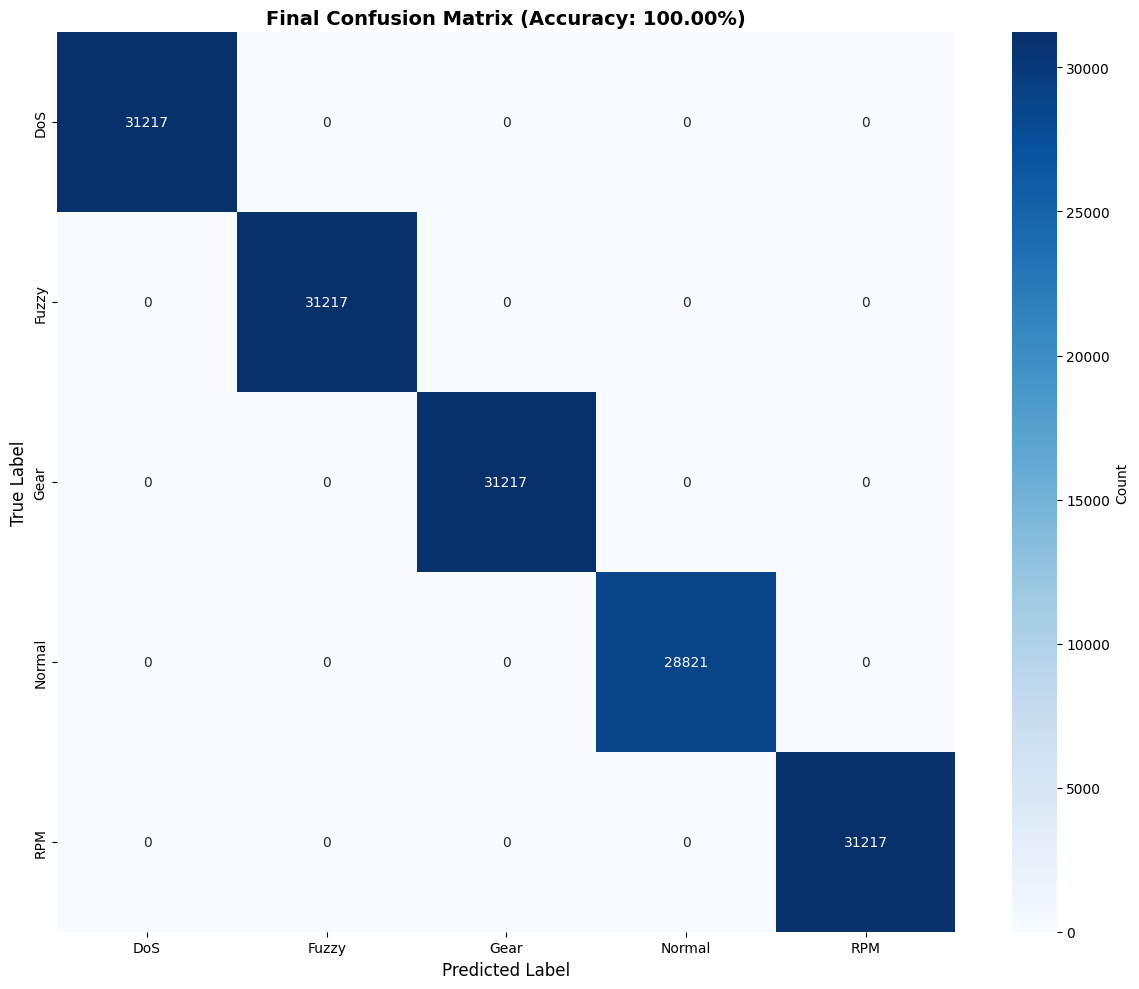


PER-CLASS ACCURACY
DoS             → 100.00%
Fuzzy           → 100.00%
Gear            → 100.00%
Normal          → 100.00%
RPM             → 100.00%


In [3]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load the full scrubbed dataset
print("Loading full dataset for final training...")
df = pd.read_csv('final_train_ready_scrubbed.csv')

# 2. Extract features and target
X = df.drop(columns=['Label_Encoded', 'Label'])
y = df['Label_Encoded']

# 3. Get the BEST parameters from Grid Search
best_params = grid_search.best_params_
print(f"\nUsing Best Parameters from GridSearch:")
print(f"  n_estimators: {best_params['n_estimators']}")
print(f"  learning_rate: {best_params['learning_rate']}")
print(f"  max_depth: {best_params['estimator__max_depth']}")

# 4. Split Full Data: 80% Train / 20% Test
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nFinal Training Set Size: {len(X_train_full)} samples")
print(f"Final Test Set Size: {len(X_test_full)} samples")

# 5. Train FINAL Model with Best Parameters on FULL dataset
print("\nTraining FINAL AdaBoost model with best parameters...")
final_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_params['estimator__max_depth']),
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)

final_model.fit(X_train_full, y_train_full)
print("Final model training completed!")

# 6. Make Predictions
print("\nGenerating predictions...")
y_pred_final = final_model.predict(X_test_full)

# 7. Calculate Accuracy
final_accuracy = accuracy_score(y_test_full, y_pred_final)
print(f"\n{'='*60}")
print(f"FINAL MODEL ACCURACY: {final_accuracy*100:.2f}%")
print(f"{'='*60}")

# 8. CLASSIFICATION REPORT
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test_full, y_pred_final, target_names=encoder.classes_))

# 9. CONFUSION MATRIX - Numerical
print("\n" + "="*60)
print("CONFUSION MATRIX (Numerical)")
print("="*60)
cm_final = confusion_matrix(y_test_full, y_pred_final)
print(cm_final)

# 10. CONFUSION MATRIX - Visualization
print("\nGenerating Confusion Matrix Heatmap...")
plt.figure(figsize=(12, 10))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Final Confusion Matrix (Accuracy: {final_accuracy*100:.2f}%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 11. Per-Class Accuracy
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
cm_normalized = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]
for i, class_name in enumerate(encoder.classes_):
    per_class_acc = cm_normalized[i, i] * 100
    print(f"{class_name:15} → {per_class_acc:6.2f}%")

---
## Section 4: EXTENDED MODEL COMPARISON (10 Models)
### Original Models: AdaBoost, Naive Bayes, Decision Tree, XGBoost
### NEW Models: SVM (RBF), SVM (Linear), Random Forest, Logistic Regression, KNN, Neural Network (MLP), Extra Trees

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import (
    AdaBoostClassifier, 
    RandomForestClassifier, 
    ExtraTreesClassifier,
    GradientBoostingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# 1. Load the full dataset
# ============================================================
print("="*70)
print("EXTENDED MODEL COMPARISON: 10 Models for Car Attack Detection")
print("="*70)

df = pd.read_csv('final_train_ready_scrubbed.csv')
X = df.drop(columns=['Label_Encoded', 'Label'])
y = df['Label_Encoded']

# 2. Split data: 80% Train / 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTraining Set: {len(X_train)} samples")
print(f"Test Set: {len(X_test)} samples")

# 3. Scale features for SVM, KNN, MLP, Logistic Regression (they need it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(encoder.classes_)} → {list(encoder.classes_)}\n")

# ============================================================
# 4. Define ALL 10 Models
# ============================================================
models = {
    # ---- ORIGINAL 4 MODELS (from Cars Attack detection Models.ipynb) ----
    'AdaBoost': {
        'model': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=grid_search.best_params_['estimator__max_depth']),
            n_estimators=grid_search.best_params_['n_estimators'],
            learning_rate=grid_search.best_params_['learning_rate'],
            random_state=42
        ),
        'scaled': False
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'scaled': False
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(max_depth=10, random_state=42),
        'scaled': False
    },
    'XGBoost': {
        'model': XGBClassifier(
            n_estimators=100, max_depth=6, random_state=42, eval_metric='mlogloss'
        ),
        'scaled': False
    },
    
    # ---- NEW 6 MODELS ----
    'SVM (RBF)': {
        'model': SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
        'scaled': True  # SVM needs scaled data
    },
    'Random Forest': {
        'model': RandomForestClassifier(
            n_estimators=100, max_depth=15, random_state=42, n_jobs=-1
        ),
        'scaled': False
    },
    'Logistic Regression': {
        'model': LogisticRegression(
            max_iter=1000, random_state=42, solver='lbfgs', n_jobs=-1
        ),
        'scaled': True  # LR benefits from scaling
    },
    'KNN': {
        'model': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        'scaled': True  # KNN needs scaled data (distance-based)
    },
    'Neural Network (MLP)': {
        'model': MLPClassifier(
            hidden_layer_sizes=(128, 64), max_iter=300, random_state=42,
            early_stopping=True, validation_fraction=0.1
        ),
        'scaled': True  # MLP needs scaled data
    },
    'Extra Trees': {
        'model': ExtraTreesClassifier(
            n_estimators=100, max_depth=15, random_state=42, n_jobs=-1
        ),
        'scaled': False
    },
}

# ============================================================
# 5. Train and Evaluate ALL Models
# ============================================================
results = {}

for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"  Training: {name}")
    print(f"{'='*60}")
    
    model = config['model']
    use_scaled = config['scaled']
    
    # Choose scaled or unscaled data
    X_tr = X_train_scaled if use_scaled else X_train
    X_te = X_test_scaled if use_scaled else X_test
    
    # Train
    start_time = time.time()
    model.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict on both train and test sets
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    f1 = f1_score(y_test, y_pred_test, average='weighted')
    cm = confusion_matrix(y_test, y_pred_test)
    report = classification_report(y_test, y_pred_test, target_names=encoder.classes_, output_dict=True)
    
    # Store results
    results[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'train_time': train_time,
        'confusion_matrix': cm,
        'report': report,
        'predictions': y_pred_test
    }
    
    print(f"  Training Time: {train_time:.2f}s")
    print(f"  Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"  Test Accuracy:  {test_accuracy*100:.2f}%")
    print(f"  Precision:      {precision*100:.2f}%")
    print(f"  Recall:         {recall*100:.2f}%")
    print(f"  F1-Score:       {f1*100:.2f}%")
    print(f"  Gap (Train-Test): {(train_accuracy - test_accuracy)*100:.2f}%")

print(f"\n{'='*60}")
print("  ALL 10 MODELS TRAINED SUCCESSFULLY!")
print(f"{'='*60}")

EXTENDED MODEL COMPARISON: 10 Models for Car Attack Detection

Training Set: 614752 samples
Test Set: 153689 samples
Features: 11
Classes: 5 → ['DoS', 'Fuzzy', 'Gear', 'Normal', 'RPM']


  Training: AdaBoost
  Training Time: 103.34s
  Train Accuracy: 100.00%
  Test Accuracy:  100.00%
  Precision:      100.00%
  Recall:         100.00%
  F1-Score:       100.00%
  Gap (Train-Test): 0.00%

  Training: Naive Bayes
  Training Time: 0.16s
  Train Accuracy: 99.02%
  Test Accuracy:  99.03%
  Precision:      99.03%
  Recall:         99.03%
  F1-Score:       99.03%
  Gap (Train-Test): -0.00%

  Training: Decision Tree
  Training Time: 1.23s
  Train Accuracy: 99.95%
  Test Accuracy:  99.94%
  Precision:      99.94%
  Recall:         99.94%
  F1-Score:       99.94%
  Gap (Train-Test): 0.01%

  Training: XGBoost
  Training Time: 7.33s
  Train Accuracy: 100.00%
  Test Accuracy:  100.00%
  Precision:      100.00%
  Recall:         100.00%
  F1-Score:       100.00%
  Gap (Train-Test): 0.00%

  Trainin

## Section 5: Summary Comparison Table & Overfitting Analysis

In [11]:
# ============================================================
# COMPREHENSIVE COMPARISON TABLE
# ============================================================
print("="*90)
print("COMPREHENSIVE MODEL COMPARISON TABLE (Sorted by Test Accuracy, then Speed)")
print("="*90 + "\n")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Acc (%)': [results[m]['train_accuracy']*100 for m in results],
    'Test Acc (%)': [results[m]['test_accuracy']*100 for m in results],
    'Precision (%)': [results[m]['precision']*100 for m in results],
    'Recall (%)': [results[m]['recall']*100 for m in results],
    'F1-Score (%)': [results[m]['f1_score']*100 for m in results],
    'Gap (%)': [(results[m]['train_accuracy'] - results[m]['test_accuracy'])*100 for m in results],
    'Time (s)': [results[m]['train_time'] for m in results]
})

# Sort by Test Accuracy (descending) THEN by Training Time (ascending) as tiebreaker
comparison_df = comparison_df.sort_values(
    ['Test Acc (%)', 'Time (s)'], 
    ascending=[False, True]
).reset_index(drop=True)
comparison_df.index = comparison_df.index + 1  # Start ranking from 1
print(comparison_df.to_string())

# ============================================================
# OVERFITTING ANALYSIS
# ============================================================
print(f"\n{'='*90}")
print("OVERFITTING ANALYSIS")
print(f"{'='*90}")

for _, row in comparison_df.iterrows():
    diff = row['Gap (%)']
    name = row['Model']
    if diff > 5:
        status = "🔴 Significant overfitting!"
    elif diff > 2:
        status = "🟡 Mild overfitting"
    elif diff > -1:
        status = "🟢 Good generalization"
    else:
        status = "🔵 Unusual: Test > Train"
    print(f"  {name:25} → {status} (Δ = {diff:.2f}%)")

# ============================================================
# BEST MODEL RECOMMENDATION
# ============================================================
best_model_name = comparison_df.iloc[0]['Model']
best_acc = comparison_df.iloc[0]['Test Acc (%)']
best_f1 = comparison_df.iloc[0]['F1-Score (%)']
best_time = comparison_df.iloc[0]['Time (s)']

print(f"\n{'='*90}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_acc:.2f}%  |  F1-Score: {best_f1:.2f}%  |  Time: {best_time:.2f}s")
print(f"{'='*90}")

COMPREHENSIVE MODEL COMPARISON TABLE (Sorted by Test Accuracy, then Speed)

                   Model  Train Acc (%)  Test Acc (%)  Precision (%)  Recall (%)  F1-Score (%)   Gap (%)    Time (s)
1            Extra Trees     100.000000    100.000000     100.000000  100.000000    100.000000  0.000000    6.747255
2                XGBoost     100.000000    100.000000     100.000000  100.000000    100.000000  0.000000    7.326878
3          Random Forest     100.000000    100.000000     100.000000  100.000000    100.000000  0.000000    9.337092
4               AdaBoost     100.000000    100.000000     100.000000  100.000000    100.000000  0.000000  103.343695
5              SVM (RBF)      99.993819     99.994144      99.994145   99.994144     99.994144 -0.000325   30.832532
6   Neural Network (MLP)      99.995771     99.992192      99.992193   99.992192     99.992192  0.003579   65.099508
7                    KNN      99.986824     99.981131      99.981133   99.981131     99.981131  0.005693 

## Section 6: Detailed Classification Reports for Each Model

In [7]:
# ============================================================
# DETAILED CLASSIFICATION REPORTS FOR ALL 10 MODELS
# ============================================================

for name in results.keys():
    print(f"\n{'='*60}")
    print(f"  {name.upper()} - CLASSIFICATION REPORT")
    print(f"{'='*60}")
    print(classification_report(y_test, results[name]['predictions'], target_names=encoder.classes_))


  ADABOOST - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     31217
       Fuzzy       1.00      1.00      1.00     31217
        Gear       1.00      1.00      1.00     31217
      Normal       1.00      1.00      1.00     28821
         RPM       1.00      1.00      1.00     31217

    accuracy                           1.00    153689
   macro avg       1.00      1.00      1.00    153689
weighted avg       1.00      1.00      1.00    153689


  NAIVE BAYES - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     31217
       Fuzzy       0.98      0.97      0.98     31217
        Gear       1.00      1.00      1.00     31217
      Normal       0.97      0.98      0.97     28821
         RPM       1.00      1.00      1.00     31217

    accuracy                           0.99    153689
   macro avg       0.99      0.99      0.99    153689
we

## Section 7: Confusion Matrix Heatmaps for All 10 Models

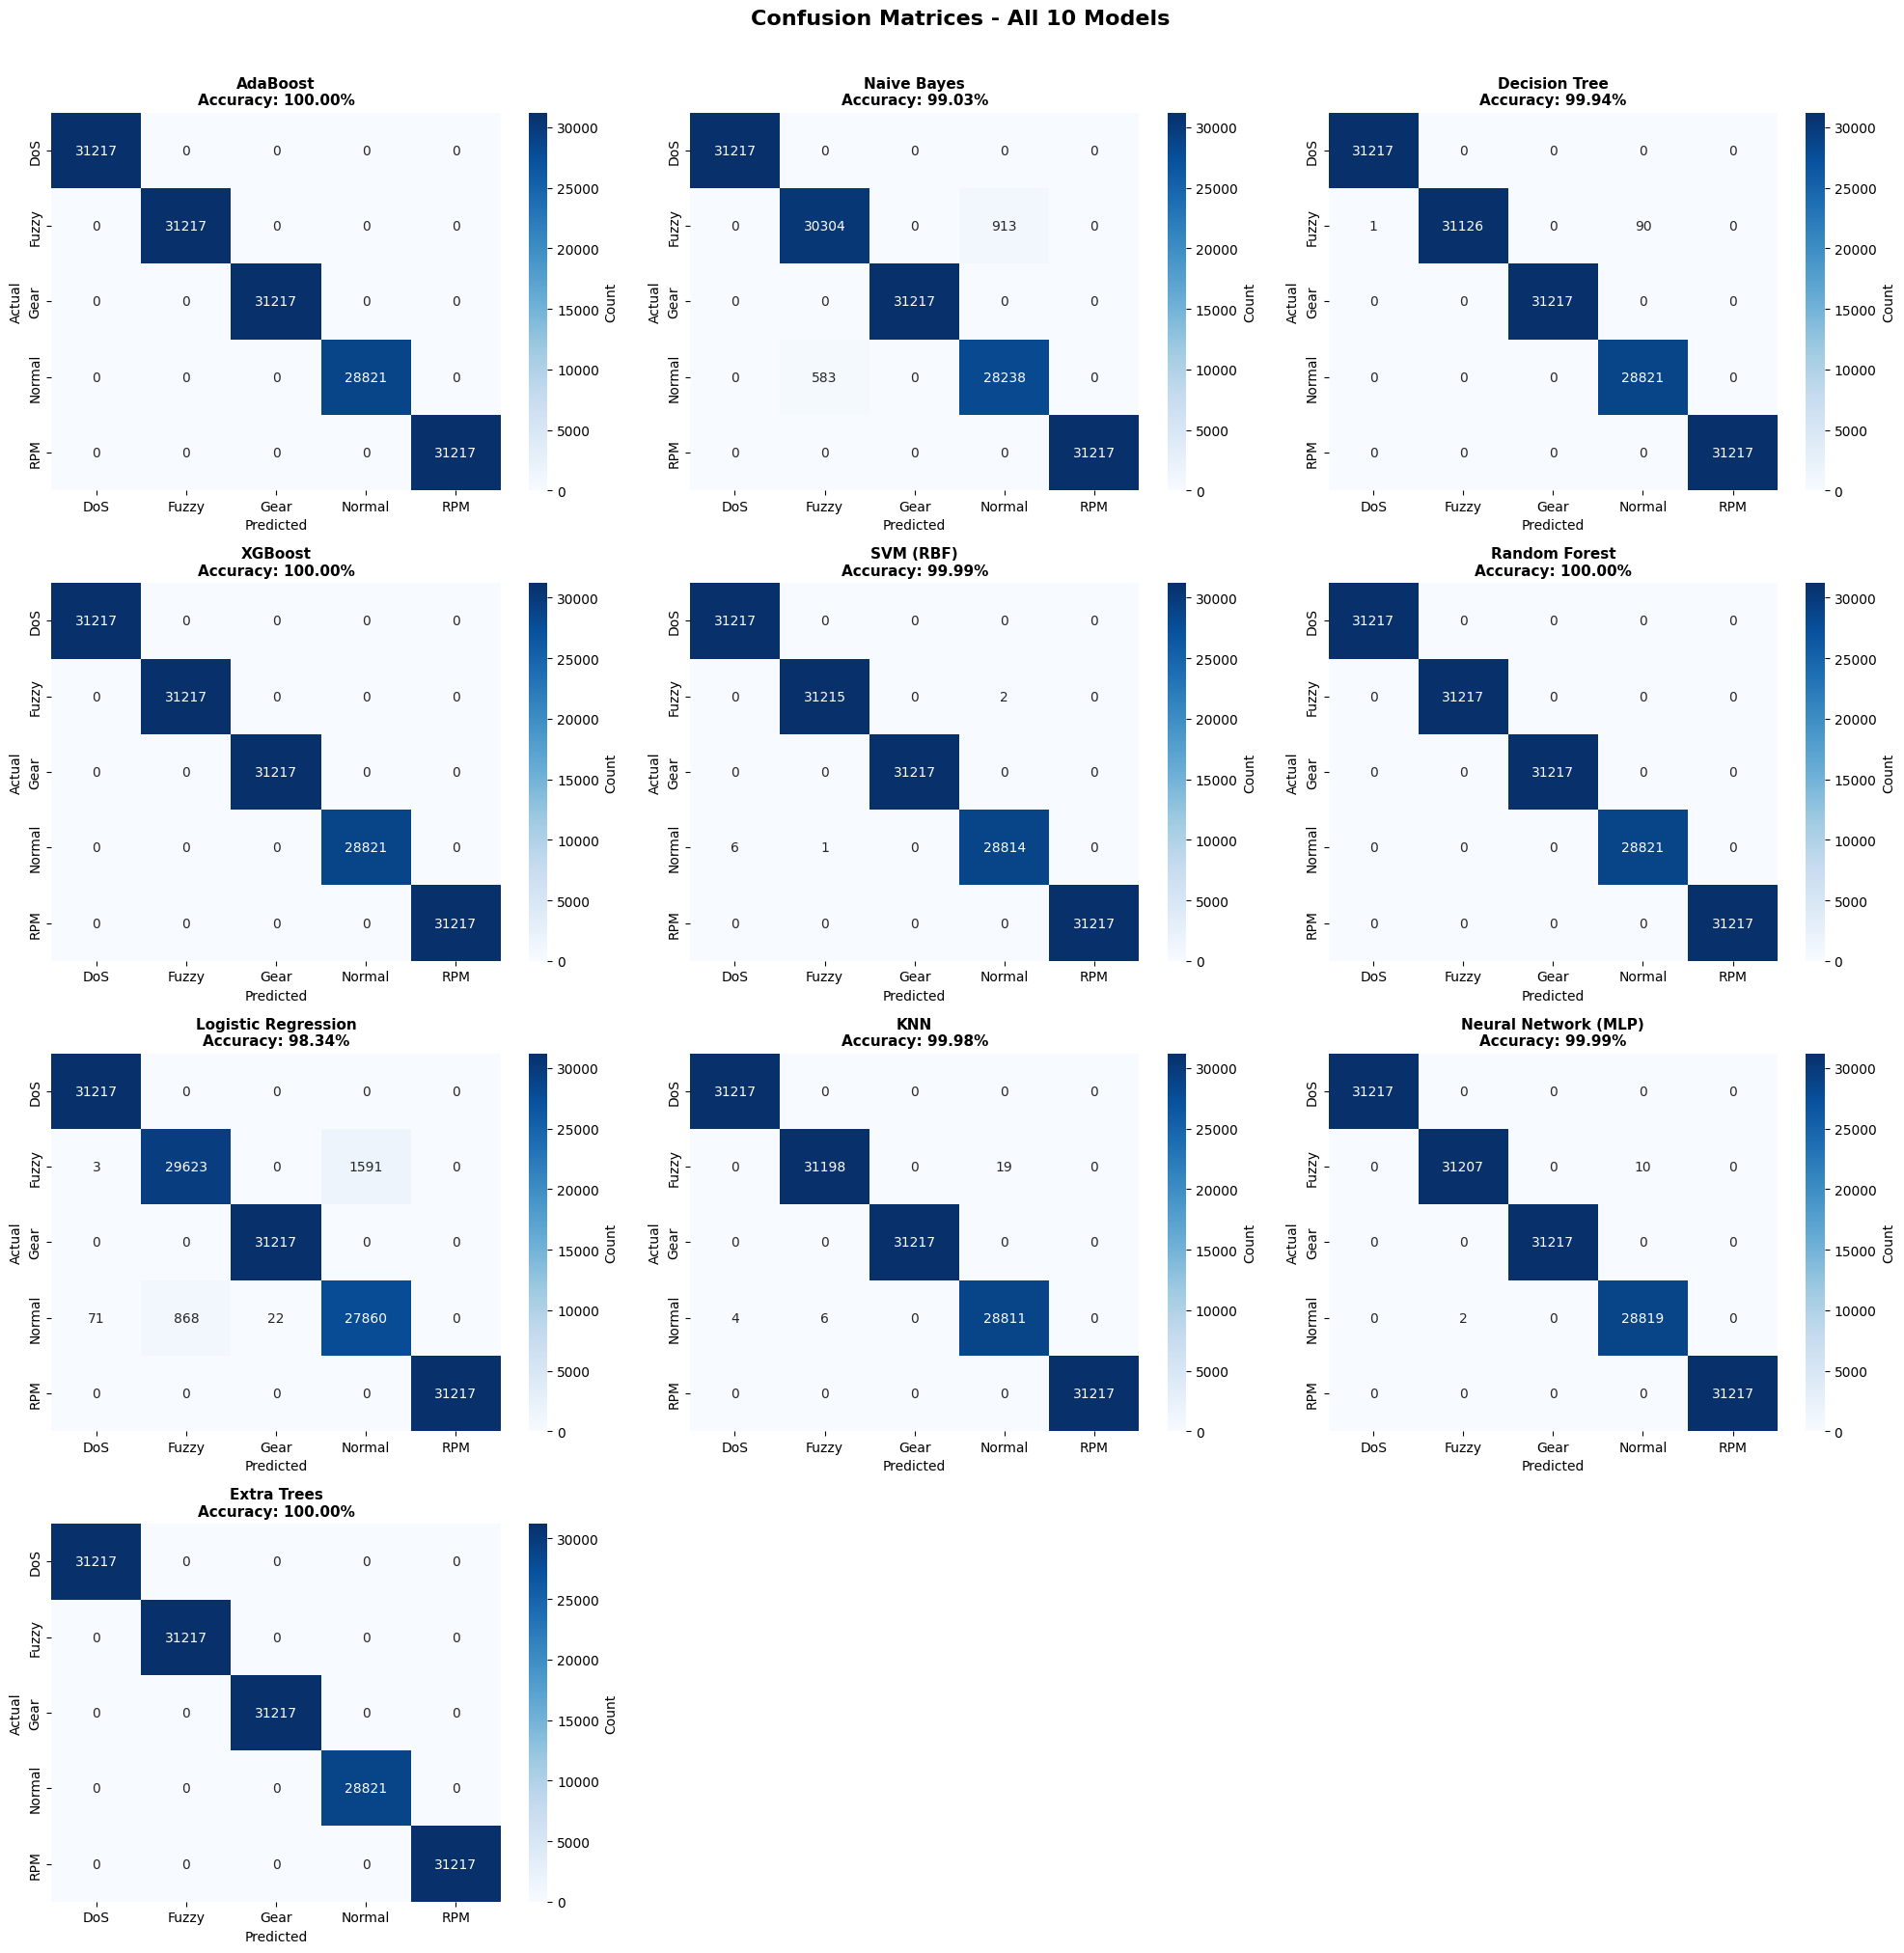

In [8]:
# ============================================================
# CONFUSION MATRIX HEATMAPS FOR ALL 10 MODELS
# ============================================================

num_models = len(results)
cols = 3
rows = (num_models + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    sns.heatmap(
        result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
        xticklabels=encoder.classes_, yticklabels=encoder.classes_,
        ax=axes[idx], cbar_kws={'label': 'Count'}
    )
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    axes[idx].set_title(f"{name}\nAccuracy: {result['test_accuracy']*100:.2f}%", 
                        fontsize=11, fontweight='bold')

# Hide unused subplots
for idx in range(num_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices - All 10 Models', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## Section 8: Visual Comparison Charts (Accuracy, F1-Score, Training Time)

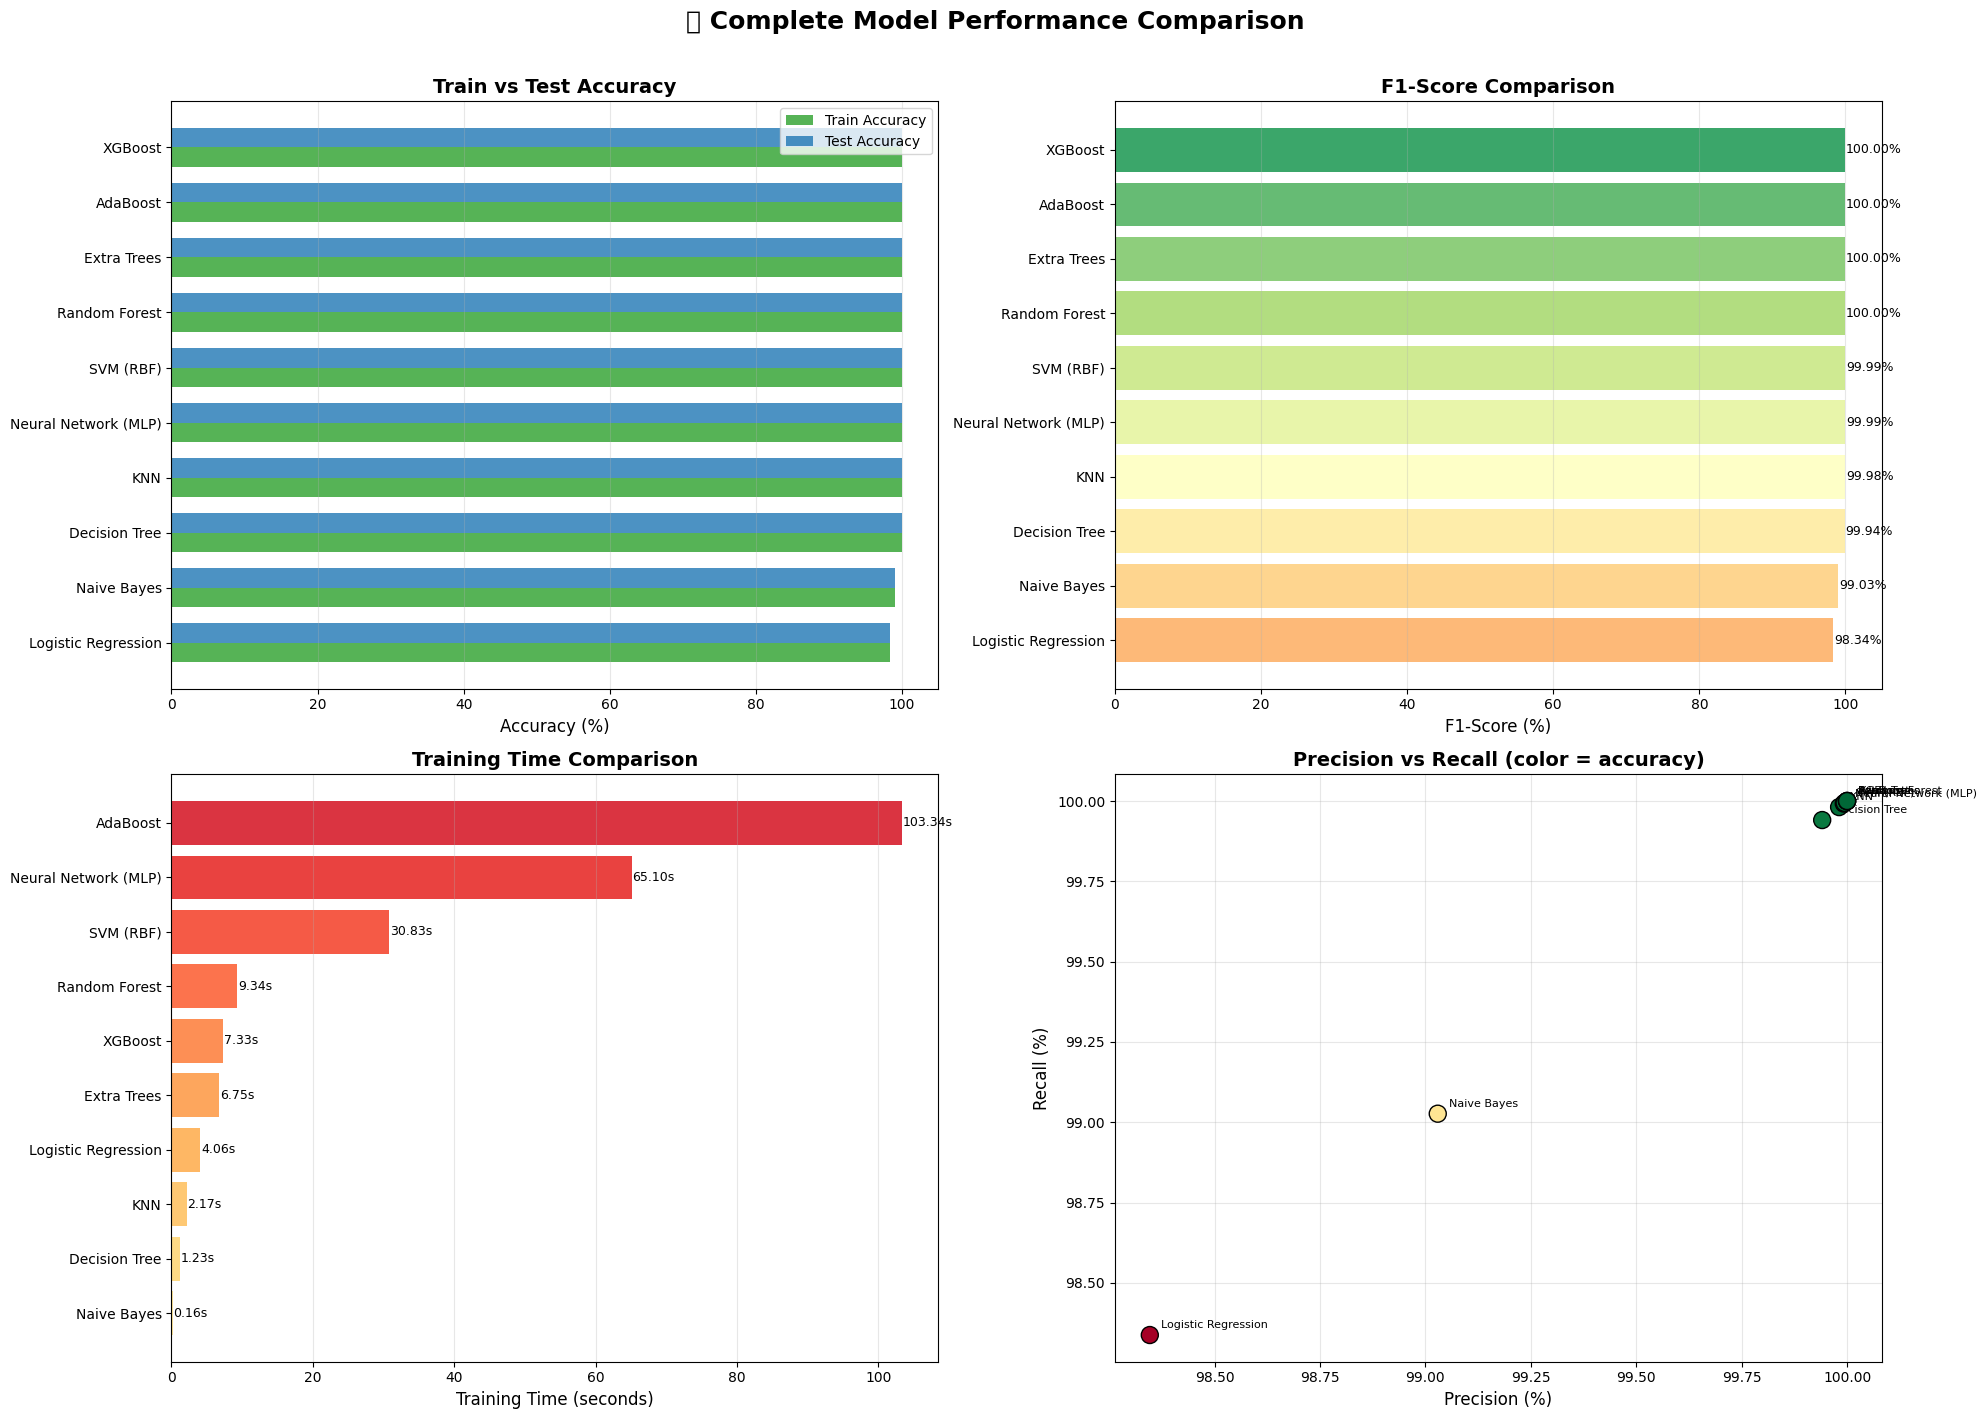

In [9]:
# ============================================================
# VISUAL COMPARISON CHARTS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Sort comparison_df for consistent plotting
df_plot = comparison_df.sort_values('Test Acc (%)', ascending=True)

# --- CHART 1: Train vs Test Accuracy ---
ax1 = axes[0, 0]
y_pos = np.arange(len(df_plot))
bar_height = 0.35

ax1.barh(y_pos - bar_height/2, df_plot['Train Acc (%)'], bar_height, 
         label='Train Accuracy', color='#2ca02c', alpha=0.8)
ax1.barh(y_pos + bar_height/2, df_plot['Test Acc (%)'], bar_height, 
         label='Test Accuracy', color='#1f77b4', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(df_plot['Model'], fontsize=10)
ax1.set_xlabel('Accuracy (%)', fontsize=12)
ax1.set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# --- CHART 2: F1-Score Comparison ---
ax2 = axes[0, 1]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(df_plot)))
bars = ax2.barh(df_plot['Model'], df_plot['F1-Score (%)'], color=colors, alpha=0.85)
ax2.set_xlabel('F1-Score (%)', fontsize=12)
ax2.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar, val in zip(bars, df_plot['F1-Score (%)']):
    ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{val:.2f}%', va='center', fontsize=9)

# --- CHART 3: Training Time ---
ax3 = axes[1, 0]
df_time = comparison_df.sort_values('Time (s)', ascending=True)
colors_time = plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(df_time)))
bars = ax3.barh(df_time['Model'], df_time['Time (s)'], color=colors_time, alpha=0.85)
ax3.set_xlabel('Training Time (seconds)', fontsize=12)
ax3.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

for bar, val in zip(bars, df_time['Time (s)']):
    ax3.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{val:.2f}s', va='center', fontsize=9)

# --- CHART 4: Precision vs Recall ---
ax4 = axes[1, 1]
ax4.scatter(df_plot['Precision (%)'], df_plot['Recall (%)'], 
            s=150, c=df_plot['Test Acc (%)'], cmap='RdYlGn', 
            edgecolors='black', linewidth=1, zorder=5)

for _, row in df_plot.iterrows():
    ax4.annotate(row['Model'], (row['Precision (%)'], row['Recall (%)']),
                 textcoords="offset points", xytext=(8, 5), fontsize=8)

ax4.set_xlabel('Precision (%)', fontsize=12)
ax4.set_ylabel('Recall (%)', fontsize=12)
ax4.set_title('Precision vs Recall (color = accuracy)', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)

plt.suptitle('📊 Complete Model Performance Comparison', fontsize=18, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## Section 9: Per-Class Accuracy Heatmap Across All Models

PER-CLASS ACCURACY ACROSS ALL MODELS

                        DoS   Fuzzy   Gear  Normal    RPM
AdaBoost              100.0  100.00  100.0  100.00  100.0
Naive Bayes           100.0   97.08  100.0   97.98  100.0
Decision Tree         100.0   99.71  100.0  100.00  100.0
XGBoost               100.0  100.00  100.0  100.00  100.0
SVM (RBF)             100.0   99.99  100.0   99.98  100.0
Random Forest         100.0  100.00  100.0  100.00  100.0
Logistic Regression   100.0   94.89  100.0   96.67  100.0
KNN                   100.0   99.94  100.0   99.97  100.0
Neural Network (MLP)  100.0   99.97  100.0   99.99  100.0
Extra Trees           100.0  100.00  100.0  100.00  100.0


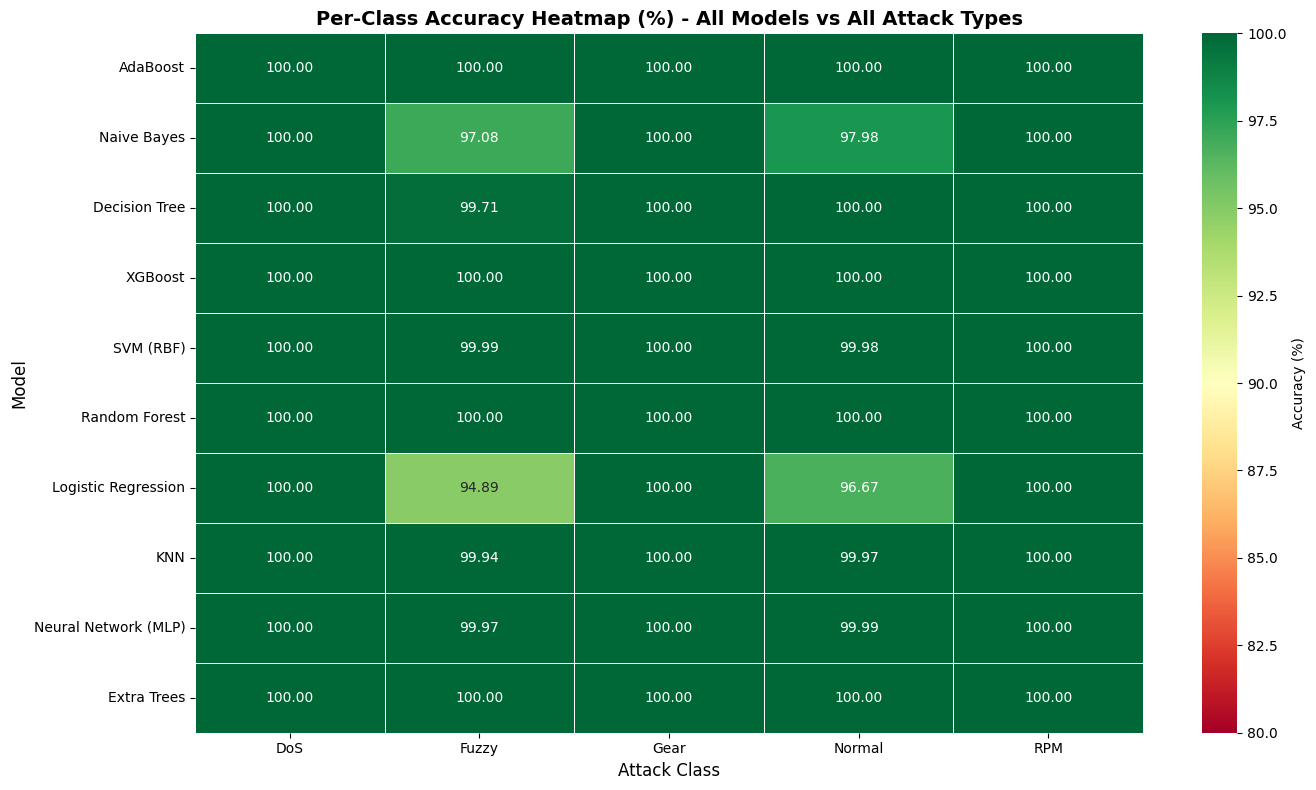


🏆 FINAL RANKINGS

  🥇 Extra Trees               | Acc: 100.00% | F1: 100.00% | Time: 6.75s
  🥈 XGBoost                   | Acc: 100.00% | F1: 100.00% | Time: 7.33s
  🥉 Random Forest             | Acc: 100.00% | F1: 100.00% | Time: 9.34s
  #4 AdaBoost                  | Acc: 100.00% | F1: 100.00% | Time: 103.34s
  #5 SVM (RBF)                 | Acc: 99.99% | F1: 99.99% | Time: 30.83s
  #6 Neural Network (MLP)      | Acc: 99.99% | F1: 99.99% | Time: 65.10s
  #7 KNN                       | Acc: 99.98% | F1: 99.98% | Time: 2.17s
  #8 Decision Tree             | Acc: 99.94% | F1: 99.94% | Time: 1.23s
  #9 Naive Bayes               | Acc: 99.03% | F1: 99.03% | Time: 0.16s
  #10 Logistic Regression       | Acc: 98.34% | F1: 98.34% | Time: 4.06s


In [12]:
# ============================================================
# PER-CLASS ACCURACY HEATMAP (Models x Classes)
# ============================================================

print("="*70)
print("PER-CLASS ACCURACY ACROSS ALL MODELS")
print("="*70 + "\n")

# Build a per-class accuracy matrix
per_class_data = {}

for name, result in results.items():
    cm = result['confusion_matrix']
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    per_class_acc = [cm_norm[i, i] * 100 for i in range(len(encoder.classes_))]
    per_class_data[name] = per_class_acc

per_class_df = pd.DataFrame(per_class_data, index=encoder.classes_).T

# Print table
print(per_class_df.round(2).to_string())

# Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(per_class_df, annot=True, fmt='.2f', cmap='RdYlGn', 
            linewidths=0.5, vmin=80, vmax=100,
            cbar_kws={'label': 'Accuracy (%)'})
plt.xlabel('Attack Class', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Per-Class Accuracy Heatmap (%) - All Models vs All Attack Types', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================
# FINAL SUMMARY
# ============================================================
print(f"\n{'='*70}")
print("🏆 FINAL RANKINGS")
print(f"{'='*70}\n")

for rank, (_, row) in enumerate(comparison_df.iterrows(), 1):
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"#{rank}"
    print(f"  {medal} {row['Model']:25} | Acc: {row['Test Acc (%)']:.2f}% | F1: {row['F1-Score (%)']:.2f}% | Time: {row['Time (s)']:.2f}s")